# EDA 

* Data from [WiDS Datathon 2021](https://www.kaggle.com/c/widsdatathon2021)

* Objective: To determine whether a patient admitted to an Intensive Care Unit (ICU) has been diagonsed with a particular type of diabetes, Diabetes Mellitus, using data from the first 24 hours of intensive care.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd # grid for plot alignment
import seaborn as sns
sns.set_palette('Set3')
sns.set_context(rc={'axes.labelsize':18,
                    'axes.titlesize':18,
                    'font.size':15,
                    'legend.fontsize':15,
                    'lines.linewidth':2.2})
import warnings
warnings.filterwarnings("ignore") # ignore plot warning messages
from ipywidgets import interact   # interactive plot
from scipy import stats # unpaired t-test

# Modeling
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_precision_recall_curve, recall_score

In [2]:
# Import training data
train = pd.read_csv("../data/TrainingWiDS2021.csv", index_col=0)
test = pd.read_csv("../data/UnlabeledWiDS2021.csv", index_col=0)

print(train.shape)
print(test.shape)

train.head()

(130157, 180)
(10234, 179)


,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
1,214826,118,68.0,22.732803,0,Caucasian,M,180.3,Floor,Floor,...,NaN,NaN,0,0,0,0,0,0,0,1
2,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,...,51.0,51.0,0,0,0,0,0,0,0,1
3,276985,118,25.0,31.952749,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0
4,262220,118,81.0,22.635548,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,...,337.0,337.0,0,0,0,0,0,0,0,0
5,201746,33,19.0,NaN,0,Caucasian,M,188.0,NaN,Accident & Emergency,...,NaN,NaN,0,0,0,0,0,0,0,0


### Which is the target (label) column to predict?

In [3]:
target = [col for col in train.columns if col not in test.columns]
target

['diabetes_mellitus']

<AxesSubplot:xlabel='diabetes_mellitus', ylabel='count'>

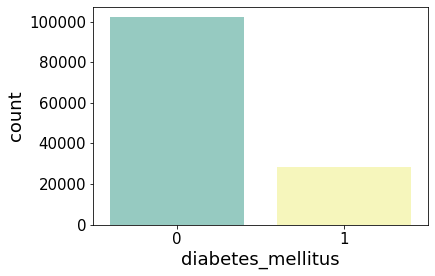

In [4]:
# Count targets
sns.countplot(train['diabetes_mellitus'])

* Unbalanced binary target distribution

## 1. Training data quality check

In [5]:
# Missing rows (just check, don't do anything yet)
prop_isnull = train.isnull().mean()
prop_isnull = prop_isnull[prop_isnull > 0]
prop_isnull

age                     0.038323
bmi                     0.034497
ethnicity               0.012193
gender                  0.000507
height                  0.015958
                          ...   
h1_arterial_ph_min      0.828607
h1_arterial_po2_max     0.825503
h1_arterial_po2_min     0.825503
h1_pao2fio2ratio_max    0.871232
h1_pao2fio2ratio_min    0.871232
Length: 160, dtype: float64

* 160 out of 180 columns have missing information, number of missing records ranging between 3.8 - 87.1%

In [6]:
# Duplicated rows
train[train.duplicated() == True]

,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus


* No duplicated rows

## 2. Data distribution

In [7]:
# Data types
train.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('O')], dtype=object)

In [8]:
# Separate data by binary, categorical, continous types

# Binary
two_unique_values = (train.nunique().values == 2) # find columns # unique value equals 2
binary = train.loc[:,two_unique_values] # select columns
binary = binary.loc[:, ~binary.isna().any()] # remove columns containing nulls

# Categorical & continuous
non_binaries = [col for col in train.columns if col not in binary.columns]
train_non_bi = train[non_binaries]
categoricals = train_non_bi.select_dtypes(include=["object"])
continuous = train_non_bi.select_dtypes(exclude=["object"])

print(binary.shape)
print(categoricals.shape)
print(continuous.shape)

(130157, 13)
(130157, 6)
(130157, 161)


## 2-1. Binary variables

In [9]:
# Missing data?
binary.isnull().mean()

elective_surgery               0.0
apache_post_operative          0.0
arf_apache                     0.0
intubated_apache               0.0
ventilated_apache              0.0
aids                           0.0
cirrhosis                      0.0
hepatic_failure                0.0
immunosuppression              0.0
leukemia                       0.0
lymphoma                       0.0
solid_tumor_with_metastasis    0.0
diabetes_mellitus              0.0
dtype: float64

* No missing rows

In [10]:
binary.drop('diabetes_mellitus', axis=1, inplace=True)
binary.shape

(130157, 12)

In [11]:
# Interactive plot to check distribution of binary variables
@interact(cols=binary.columns)
def get_countplot_binary(cols):
    plt.figure(figsize=(12,6))
    plt.title(f'Distribution of {cols}')
    sns.countplot(train[cols])
    
    # Print normalized counts of each variable
    print(binary[cols].value_counts(normalize=True).round(2))

interactive(children=(Dropdown(description='cols', options=('elective_surgery', 'apache_post_operative', 'arf_…

In [12]:
# Interactive plot to check relationships
# between the binary variables and the target variable
@interact(cols=binary.columns)
def get_countplot_diabetes(cols):
    plt.figure(figsize=(12,6))
    sns.countplot(x=cols, hue='diabetes_mellitus', data=train)
    plt.title(f'Diabetes mellitus (0, 1) and {cols}')
    plt.legend(bbox_to_anchor=(1.15, 1))
    
    # Print normalized counts of each variable
    print(train.groupby('diabetes_mellitus')[cols].value_counts(normalize=True).round(2))
    
    # This part is for categorical vaviables below
    # Rotate the xlabels if more than 4 values available
    if train[cols].nunique() > 4:
         plt.xticks(rotation=40)

interactive(children=(Dropdown(description='cols', options=('elective_surgery', 'apache_post_operative', 'arf_…

### Highlights of binary data

**arf_apache**
* When there was no diabetes: positive 2 %
* When there was diabetes: positive 6 %

    * *APACHE*: Acute Physiology and Chronic Health Evaluation II score to predict hospital mortality

## 2-2. Categorical variables

In [13]:
# Missing data per each column
categoricals.isnull().mean()

ethnicity                0.012193
gender                   0.000507
hospital_admit_source    0.255061
icu_admit_source         0.001844
icu_stay_type            0.000000
icu_type                 0.000000
dtype: float64

* 25% of the observations lack their hospital_admit_source

In [14]:
# Interactive plot to check distribution of categorical variables
@interact(cols=categoricals.columns)
def get_countplot_cat(cols):
    plt.figure(figsize=(12,6))
    plt.title(f'Distribution of {cols}')
    sns.countplot(train[cols])
    
    # Rotate the xlabels if more than 4 values available
    if categoricals[cols].nunique() > 4:
         plt.xticks(rotation=40)
            
    # Print normalized counts of each variable
    print(categoricals[cols].value_counts(normalize=True).round(2))

interactive(children=(Dropdown(description='cols', options=('ethnicity', 'gender', 'hospital_admit_source', 'i…

### Highlights of categorical data

**Ethnity**
* Highly unbalanced ratial distribution: Majority of the data (~78%) is from Caucasians.

**Gender**
* Slightly more male samples(54%) than the females (46%)

**Hospital admit source**
* More than 52% from Emergercy Department. (Remember, 25% of the patients lack this information)

**ICU admit source**
* Over 59% of patients admitted to ICU after Accident & Emergency

**ICU stay type**
* Most(95%) of the patients stay admitted to the unit, ~4% transferred to other locations, <1% readmitted

**ICU type**
* ~55% of the patients in Med-Surg ICU (=Medical Surgical Intensive Care Unit)

In [15]:
# Interactive plot to check relationships
# between the categorical variables and the target variable
interact(get_countplot_diabetes, cols=categoricals.columns)

interactive(children=(Dropdown(description='cols', options=('ethnicity', 'gender', 'hospital_admit_source', 'i…

<function __main__.get_countplot_diabetes(cols)>

**Ethnity**
* Regardless of ethnity, 20-30 % of the patients from the data had diabetes mellitus

**Gender**
* In both sexes, 21-22 % of the patiens had diabetes mellitus

**Hospital admit source, ICU admit source, ICU stay type, ICU type**
* Similar to ethnity, roughly 20-30 % of each group had diabetes mellitus

**icu_admit_source and icu_type**
* Slight changes in order of frequency when compared negative vs. positive to diabetes mellitus

## 2-3. Continuous variables

In [16]:
# Interactive plot to check distribution of continuous variables

# Excude ids from plot
except_ids = [col for col in continuous.columns if col[-2:] != 'id']

# Histograms to show distribution of continuous values
@interact(cols=except_ids)
def get_histplot(cols):
    plt.figure(figsize=(12,6))
    plt.title(f'Distribution of {cols}')
    sns.histplot(continuous[cols])
    
    plt.axvline(continuous[cols].median(), color='red')  # Median in red
    plt.axvline(continuous[cols].mean(), color='green')  # Mean in green
    
    print('Mean: ', round(continuous[cols].mean(), 1))
    print('Median: ', round(continuous[cols].median(), 1))

interactive(children=(Dropdown(description='cols', options=('age', 'bmi', 'height', 'pre_icu_los_days', 'readm…

In [17]:
# Interactive relplot between continuous variables and the target variable
@interact(cols=except_ids + ['diabetes_mellitus'])
def get_boxplot(cols):
    plt.figure(figsize=(12,6))
    sns.boxplot(x=train['diabetes_mellitus'], y=train[cols])
    plt.title(f'Diabetes mellitus (0, 1) and {cols}')
    
    # Print normalized counts of each variable
    count_diabetes = train.groupby('diabetes_mellitus')[cols].count()
    print('Total counts: ', count_diabetes.sum())
    print(' ')
    print(count_diabetes)
    print(' ')
    
    # Print mean values
    diabetes = train['diabetes_mellitus'] == 1
    positive = train[diabetes][cols]
    negative = train[~diabetes][cols]
    print('No diabetes meallitus(0)', negative.mean())
    print('Diabetes meallitus(1)', positive.mean())

interactive(children=(Dropdown(description='cols', options=('age', 'bmi', 'height', 'pre_icu_los_days', 'readm…

In [18]:
# Calculate ttest and print only the columns with significant difference
diabetes = train['diabetes_mellitus'] == 1
significant_cols = []

for col in continuous.columns:
    positive = continuous[diabetes][col]
    negative = continuous[~diabetes][col]
    tstats , p_value = stats.ttest_ind(negative.values, positive.values, nan_policy='omit')

    if p_value < 0.05:
        significant_cols.append(col)
        
print(len(significant_cols))
print(significant_cols[:5])

133
['age', 'bmi', 'icu_id', 'pre_icu_los_days', 'weight']


### Highlight of continous data

**Significant difference between groups**
* 133 out of 161 columns including age, bmi, pre_icu_los_days, weight.

In [19]:
# Highly linearly correlated continuous variable?
cols_for_corr = significant_cols + ['diabetes_mellitus']
corr = train[cols_for_corr].corr()['diabetes_mellitus'].sort_values()
corr

h1_diasbp_invasive_min   -0.103672
h1_diasbp_invasive_max   -0.088664
h1_hco3_max              -0.086883
h1_hco3_min              -0.086548
d1_diasbp_invasive_min   -0.084994
                            ...   
h1_glucose_min            0.304520
h1_glucose_max            0.316847
glucose_apache            0.354359
d1_glucose_max            0.400742
diabetes_mellitus         1.000000
Name: diabetes_mellitus, Length: 134, dtype: float64

In [20]:
# heatmap?

# 3. Data cleaning + Feature engineering

In [80]:
fin_cols = list(binary.columns) + list(categoricals.columns) + list(continuous.columns)

train_new = train[fin_cols + ['diabetes_mellitus']]
test_new = test[fin_cols]

print(train_new.shape)
print(test_new.shape)

(130157, 180)
(10234, 179)


In [81]:
train_new = train_new.sort_values('encounter_id')
test_new = test_new.sort_values('encounter_id')

train_new.set_index('encounter_id', inplace=True)
test_new.set_index('encounter_id', inplace=True)

test_new.head()

,elective_surgery,apache_post_operative,arf_apache,intubated_apache,ventilated_apache,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,...,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min
encounter_id,,,,,,,,,,,,,,,,,,,,,
135000,1,1,0,1,1,0,0,0,0,0,...,387.5,200.0,49.0,44.0,7.31,7.28,500.0,122.0,244.0,244.0
135001,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135002,0,0,0,1,1,0,0,0,0,0,...,157.5,157.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135003,0,0,0,0,1,0,0,0,0,0,...,360.0,360.0,74.0,74.0,7.21,7.21,110.0,110.0,NaN,NaN
135004,0,0,0,0,1,0,0,0,0,0,...,313.3,313.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
# Let's drop some columns of which the majority are empty rows
# First, examine the proportion of empty values of each column
prop_nulls = train_new.isnull().mean()

prop_nulls

elective_surgery         0.000000
apache_post_operative    0.000000
arf_apache               0.000000
intubated_apache         0.000000
ventilated_apache        0.000000
                           ...   
h1_arterial_po2_max      0.825503
h1_arterial_po2_min      0.825503
h1_pao2fio2ratio_max     0.871232
h1_pao2fio2ratio_min     0.871232
diabetes_mellitus        0.000000
Length: 179, dtype: float64

In [83]:
# Let's say we drop the entire rows of columns of which >=30% are empty
# since those will be hard to be imputed in the future
less_than_30p = prop_nulls[prop_nulls < 0.3]
cols_to_keep = list(less_than_30p.index)
train_new = train_new[[c for c in cols_to_keep if c in test_new.columns] + ['diabetes_mellitus']]
test_new = test_new[[c for c in test_new.columns if c in cols_to_keep]]

print(train_new.shape)
print(test_new.shape)

(130157, 105)
(10234, 104)


In [85]:
# Let's impute the rest of the empty values
def fill_nas(df):
    for col in df.columns:
        df[col] = df[col].transform(lambda x: x.fillna(x.mode()[0]))
#         if col in binary.columns:
#             df[col].transform(lambda x: x.fillna(x.mode()[0]))        
#         elif col in categoricals.columns:
#             df[col].transform(lambda x: x.fillna(x.mode()[0]))        
#         else:
#             df[col].transform(lambda x: x.fillna(x.mode()[0]))
            
fill_nas(train_new)
fill_nas(test_new)

print(train_new.isnull().sum())

elective_surgery         0
apache_post_operative    0
arf_apache               0
intubated_apache         0
ventilated_apache        0
                        ..
d1_sodium_max            0
d1_sodium_min            0
d1_wbc_max               0
d1_wbc_min               0
diabetes_mellitus        0
Length: 105, dtype: int64


In [86]:
# Convert string (categorical) values into numbers using dummies
train_new = pd.get_dummies(train_new, drop_first=True, dtype='int64')
test_new = pd.get_dummies(test_new, drop_first=True, dtype='int64')
print(train_new.shape)
print(test_new.shape)

(130157, 132)
(10234, 126)


In [72]:
# # Let's drop the rest of the missing rows for a simple modeling
# train_new = train_new.dropna()
# test_new = test_new.dropna()

# print(train_new.shape)
# print(test_new.shape)

In [89]:
# Split the data into train and test sets for supervised learning.
# Define features and the target
# features = [col for col in train_new.columns if col != 'diabetes_mellitus']
X = train_new[test_new.columns]
y = train_new['diabetes_mellitus']

# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(91109, 126)
(39048, 126)
(91109,)
(39048,)


In [90]:
# Initiate standard scaler
scaler = StandardScaler()

# Fit and transform the features from both train and test set
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
test_new = scaler.transform(test_new)

# 3. Modeling - A. Baseline

In [91]:
# Use a logistic function (sigmoidal function) for a classic binary classification problem
# in which the prediction input is a probability value between 0 and 1.

logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)
y_pred_baseline = logmodel.predict(X_test)

In [92]:
print(classification_report(y_test, y_pred_baseline))

              precision    recall  f1-score   support

           0       0.83      0.95      0.89     30471
           1       0.64      0.31      0.41      8577

    accuracy                           0.81     39048
   macro avg       0.74      0.63      0.65     39048
weighted avg       0.79      0.81      0.78     39048



<Figure size 720x720 with 0 Axes>

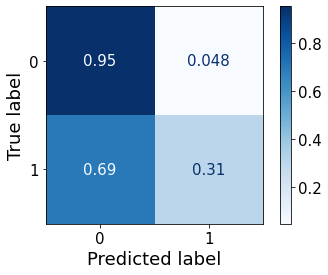

In [93]:
# Plot a confusion matrix using test sets
plt.figure(figsize=(10,10))
confusion_matrix = plot_confusion_matrix(logmodel, X_test, y_test,
                                         cmap='Blues', normalize='true')
plt.grid(False)

Recall score: 0.3052349306284249


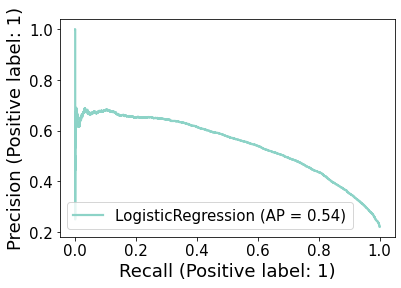

In [94]:
# Plot a precision_recall curve using test sets
# Precision: TP / (TP+FP)
# Recall: TP / (TP+FN)***

recall_base = recall_score(y_test, y_pred_baseline)
print(f'Recall score: {recall_base}')

base_precision_recall = plot_precision_recall_curve(logmodel, X_test, y_test)
base_precision_recall

# 4. Modeling - B. Beat the baseline

In [95]:
# Target proportion
y.value_counts(normalize=True)

0    0.783715
1    0.216285
Name: diabetes_mellitus, dtype: float64

+ Hyperparameter adjustment: Class weight

The ratio of not_diabetes_mellitus(0) vs. diabetes_mellitus(1) is 78 vs. 22 (%) Therefore, by defining the class weights as inverse of label distribution, we can penalize the wrong prediction of the minorities much higher than that of the majorities. To this end, we implement 'class_weight' hyperparameter of Logistic regression.

In [96]:
# Define class weights
weight = {0:22, 1:78}

# Fit agian with logistic regression
logmodel2 = LogisticRegression(class_weight=weight)
logmodel2.fit(X_train, y_train)
y_prediction_log2 = logmodel2.predict(X_test)

<Figure size 720x720 with 0 Axes>

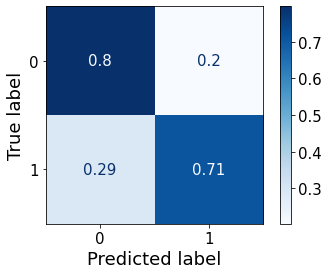

In [97]:
# Plot a confusion matrix using test sets
plt.figure(figsize=(10,10))
confusion_matrix = plot_confusion_matrix(logmodel2, X_test, y_test,
                                         cmap='Blues', normalize='true')
plt.grid(False)

In [98]:
print(classification_report(y_test, y_prediction_log2))

              precision    recall  f1-score   support

           0       0.91      0.80      0.85     30471
           1       0.50      0.71      0.58      8577

    accuracy                           0.78     39048
   macro avg       0.70      0.75      0.72     39048
weighted avg       0.82      0.78      0.79     39048



In [99]:
pred_real_test = logmodel2.predict_proba(test_new)[:,1]
pred_real_test

array([0.69955685, 0.37907004, 0.52272892, ..., 0.59262948, 0.48850803,
       0.86119365])

# 6. Submission

In [100]:
template = pd.read_csv("../submissions/SolutionTemplateWiDS2021.csv")
template.head()

,encounter_id,diabetes_mellitus
0,135000,NaN
1,135001,NaN
2,135002,NaN
3,135003,NaN
4,135004,NaN


In [101]:
template['diabetes_mellitus'] = pd.Series(pred_real_test)
template.head()

,encounter_id,diabetes_mellitus
0,135000,0.699557
1,135001,0.379070
2,135002,0.522729
3,135003,0.831375
4,135004,0.384912


In [103]:
template.isnull().sum()

encounter_id         0
diabetes_mellitus    0
dtype: int64

In [102]:
#Convert DataFrame to a csv file that can be uploaded
#This is saved in the same directory as your notebook
filename = 'Diabetes Mellitus Predictions 1.csv'

template.to_csv(f'../submissions/{filename}', index=False)

print('Saved file: ' + filename)

Saved file: Diabetes Mellitus Predictions 1.csv
